In [268]:
import os
import torch
from torch import nn
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
import uuid
from IPython.display import clear_output

In [269]:
# variables:
num_epochs = 50
noise_dimension = 50
batch_size = 128
#unique_run_id = str(uuid.uuid4())
print_stats_after_batch = 100
optimizer_lr = 0.0002
optimizer_betas = (.5, .999)
genertor_output_image_shape = 28 * 28 * 1
device = "cpu" # "mps"

In [270]:
torch.autograd.set_detect_anomaly(False)
torch.autograd.profiler.profile(False)
torch.autograd.profiler.emit_nvtx(False)
torch.backends.cudnn.benchmark = True
torch.device(device)

device(type='cpu')

In [271]:
class Generator(nn.Module):
  def __init__(self,):
    super().__init__()
    self.layers = nn.Sequential(
      # First upsampling
      nn.Linear(noise_dimension, 128, bias=False),
      nn.BatchNorm1d(128, 0.8),
      nn.LeakyReLU(0.25),
      # Second upsampling
      nn.Linear(128, 256, bias=False),
      nn.BatchNorm1d(256, 0.8),
      nn.LeakyReLU(0.25),
      # Third upsampling
      nn.Linear(256, 512, bias=False),
      nn.BatchNorm1d(512, 0.8),
      nn.LeakyReLU(0.25),
      # Final upsampling
      nn.Linear(512, genertor_output_image_shape, bias=False),
      nn.Tanh()
    )

  def forward(self, x):
    return self.layers(x)

In [272]:
class Discriminator(nn.Module):
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Linear(genertor_output_image_shape, 1024), 
      nn.LeakyReLU(0.25),
      nn.Linear(1024, 512), 
      nn.LeakyReLU(0.25),
      nn.Linear(512, 256), 
      nn.LeakyReLU(0.25),
      nn.Linear(256, 1),
      nn.Sigmoid()
    )

  def forward(self, x):
    return self.layers(x)

In [273]:
def generate_noise(number_of_images = 1, noise_dimension = noise_dimension):
  return torch.randn(number_of_images, noise_dimension)

def generate_image(generator, epoch = 0, batch = 0):
  images = []
  noise = generate_noise(batch_size)
  generator.eval()
  images = generator(noise)
  return images

def plot_images(images, epoch = 0, batch = 0):
  fig, axs = plt.subplots(1, 4, figsize=(12, 2.5))
  for i in range(4):
    image = images[i]
    image = image.cpu().detach().numpy()
    image = np.reshape(image, (28, 28))
    axs[i].imshow(image, cmap='gray')
    axs[i].axis("off")
  mid = (fig.subplotpars.right + fig.subplotpars.left)/2
  plt.suptitle(f"Epoch: {epoch}, batch: {batch}")
    
def print_training_progress(batch, generator_loss, discriminator_loss):
  print('Losses after mini-batch %5d: generator %e, discriminator %e' %
        (batch, generator_loss, discriminator_loss))

In [274]:
def prepare_dataset():
  dataset = MNIST(os.getcwd(), download=True, train=True, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
  ]))
  trainloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
  return trainloader

In [275]:
generator = Generator()
generator.to(device)
generator_optimizer = torch.optim.AdamW(generator.parameters(), lr=optimizer_lr, betas=optimizer_betas)
discriminator = Discriminator()
discriminator.to(device)
discriminator_optimizer = torch.optim.AdamW(discriminator.parameters(), lr=optimizer_lr, betas=optimizer_betas)
loss_function = nn.BCELoss()

In [276]:
def zero_grad(model):
    for param in model.parameters():
        param.grad = None

def forward_and_backward(model, data, targets):
  outputs = model(data)
  error = loss_function(outputs, targets)
  error.backward()
  return error.item()

In [277]:
def perform_train_step(real_data):
  real_label, fake_label = 1.0, 0.0
  real_images = real_data[0].to(device)
  actual_batch_size = real_images.size(0)
  labels = torch.full((actual_batch_size,1), real_label, device=device)
  
  zero_grad(discriminator)
  real_images = real_images.view(real_images.size(0), -1)
  error_real_images = forward_and_backward(discriminator, real_images, labels)
  noise = generate_noise(actual_batch_size)
  generated_images = generator(noise)
  labels.fill_(fake_label)
  error_generated_images = forward_and_backward(discriminator, generated_images.detach(), labels)
  discriminator_optimizer.step()
  
  zero_grad(generator)
  labels.fill_(real_label)
  error_generator = forward_and_backward(discriminator, generated_images, labels)
  generator_optimizer.step()
  
  error_discriminator = error_real_images + error_generated_images
  return error_generator, error_discriminator

In [278]:
gen_losses_mean = []
dis_losses_mean = []

def perform_epoch(dataloader, epoch):
  gen_losses = []
  dis_losses = []
  for batch_no, real_data in enumerate(dataloader, 0):
    generator_loss_val, discriminator_loss_val = perform_train_step(real_data)
    if batch_no % print_stats_after_batch == 0:
      gen_losses.append(generator_loss_val)
      dis_losses.append(discriminator_loss_val)
      print_training_progress(batch_no, generator_loss_val, discriminator_loss_val)
      images = generate_image(generator, epoch, batch_no)

  gen_losses_mean.append(np.mean(np.array(gen_losses)))
  dis_losses_mean.append(np.mean(np.array(dis_losses)))
  torch.cuda.empty_cache()
  return images

def plot_losses():
  print("this is gen losses mean: ", gen_losses_mean)
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
  ax1.plot(gen_losses_mean)
  ax1.set_title("Generator Loss")
  ax2.plot(dis_losses_mean)
  ax2.set_title("Discriminator Loss")

In [279]:
def train_gan():
  torch.manual_seed(78)
  dataloader = prepare_dataset()
  for epoch in range(num_epochs):
    print(f'Starting epoch {epoch}...')
    images = perform_epoch(dataloader, epoch)
  plot_images(images)
  plot_losses()
  print('Finished run')

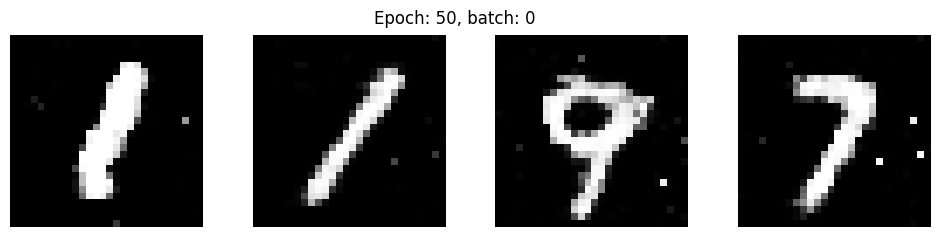

In [282]:
plot_images(generate_image(generator), epoch=50)

Starting epoch 0...
Losses after mini-batch     0: generator 6.987744e-01, discriminator 1.375499e+00
Losses after mini-batch   100: generator 1.407554e+00, discriminator 5.121467e-01
Losses after mini-batch   200: generator 7.774904e-01, discriminator 1.228971e+00
Losses after mini-batch   300: generator 3.085560e+00, discriminator 2.493603e-01
Losses after mini-batch   400: generator 3.258543e+00, discriminator 2.385267e-01
Starting epoch 1...
Losses after mini-batch     0: generator 4.913871e+00, discriminator 1.236544e-01
Losses after mini-batch   100: generator 4.857492e+00, discriminator 6.530880e-01
Losses after mini-batch   200: generator 1.652887e+00, discriminator 5.179725e-01
Losses after mini-batch   300: generator 4.216901e+00, discriminator 1.638397e-01
Losses after mini-batch   400: generator 4.062884e+00, discriminator 2.556506e-01
Starting epoch 2...
Losses after mini-batch     0: generator 7.133960e+00, discriminator 3.593194e-02
Losses after mini-batch   100: generat

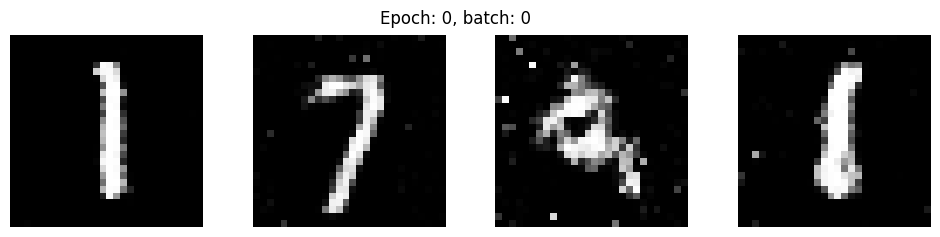

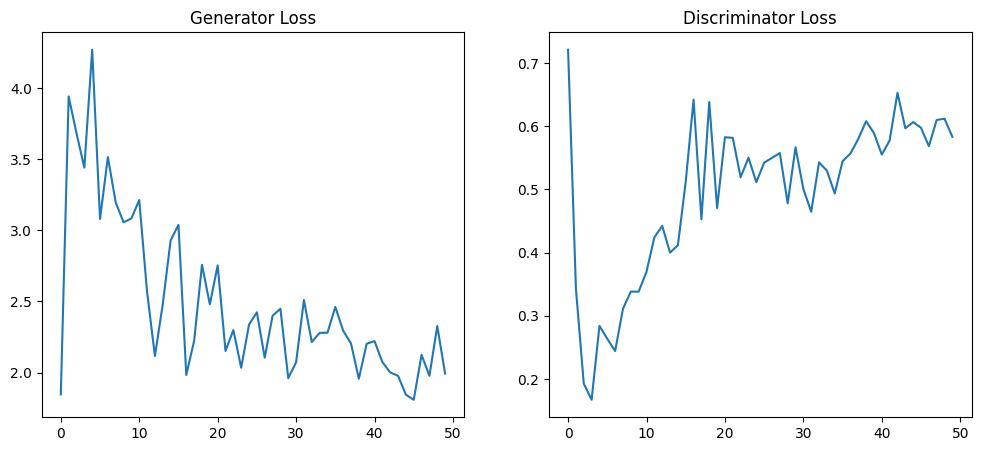

In [281]:
train_gan()